# Discord Activity Analysis
This notebook analyzes Discord activity data from both text and voice channels.
We will visualize monthly activity trends, top users, and weekly activity distribution.

In [77]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np

# Load the data
message_data = pd.read_json('data/messagedata.json')
voice_data = pd.read_json('data/voicedata.json')

# Parse datetime columns
message_data['logDate'] = pd.to_datetime(message_data['logDate'])
voice_data['when'] = pd.to_datetime(voice_data['when'])

# Add activity type for differentiation
message_data['type'] = 'text'
voice_data['type'] = 'voice'

# Convert voice duration from seconds to hours
voice_data['duration_hours'] = voice_data['duration'] / 3600

# Include a derived column for voice activity count (1 per entry)
voice_data['activity_count'] = 1


In [78]:
# Daily, Weekly, and Monthly Trends
message_data['day'] = message_data['logDate'].dt.to_period('D').dt.to_timestamp()
voice_data['day'] = voice_data['when'].dt.to_period('D').dt.to_timestamp()

message_data['week'] = message_data['logDate'].dt.to_period('W').dt.to_timestamp()
voice_data['week'] = voice_data['when'].dt.to_period('W').dt.to_timestamp()

message_data['month'] = message_data['logDate'].dt.to_period('M').dt.to_timestamp()
voice_data['month'] = voice_data['when'].dt.to_period('M').dt.to_timestamp()

# Aggregate data for text and voice
text_daily = message_data.groupby('day').size().reset_index(name='messages')
voice_daily = voice_data.groupby('day')['duration_hours'].sum().reset_index(name='hours')

text_weekly = message_data.groupby('week').size().reset_index(name='messages')
voice_weekly = voice_data.groupby('week')['duration_hours'].sum().reset_index(name='hours')

text_monthly = message_data.groupby('month').size().reset_index(name='messages')
voice_monthly = voice_data.groupby('month')['duration_hours'].sum().reset_index(name='hours')


In [116]:
# Combined trends for median calculation
combined_daily = pd.concat([text_daily.rename(columns={'messages': 'activity'}),
                            voice_daily.rename(columns={'hours': 'activity'})]
                          ).groupby('day')['activity'].median().reset_index(name='median')

combined_weekly = pd.concat([text_weekly.rename(columns={'messages': 'activity'}),
                             voice_weekly.rename(columns={'hours': 'activity'})]
                           ).groupby('week')['activity'].median().reset_index(name='median')

combined_monthly = pd.concat([text_monthly.rename(columns={'messages': 'activity'}),
                              voice_monthly.rename(columns={'hours': 'activity'})]
                            ).groupby('month')['activity'].median().reset_index(name='median')


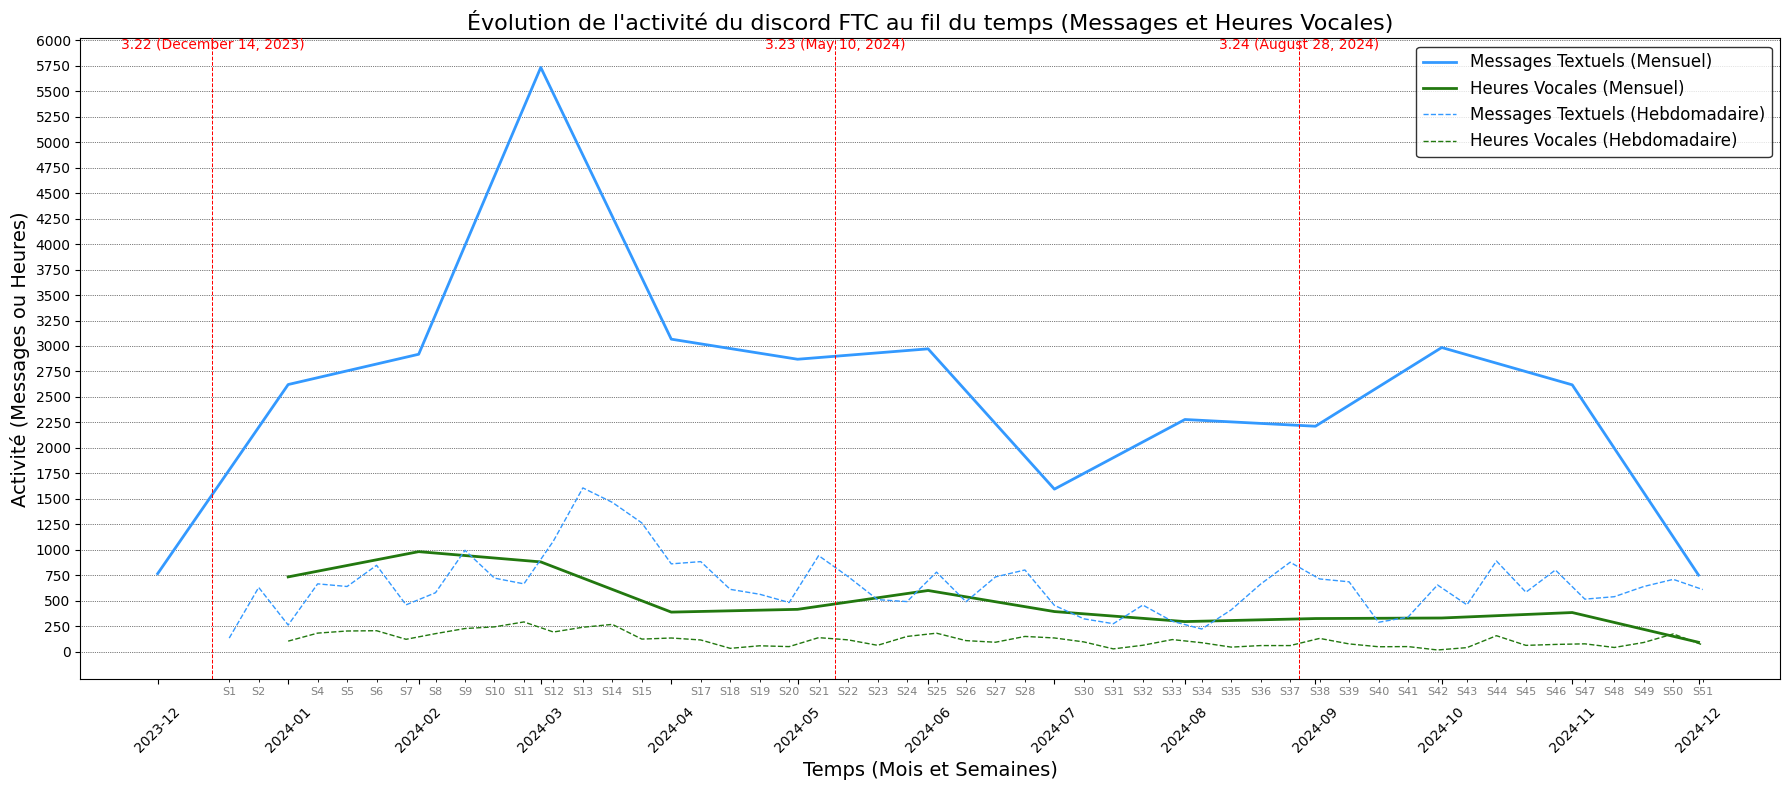

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Charger vos données réelles
message_data = pd.read_json('data/messagedata.json')
voice_data = pd.read_json('data/voicedata.json')

# Charger le fichier events.json
with open('data/events.json', 'r') as file:
    events_data = json.load(file)

# Convertir les colonnes de date en datetime
message_data['logDate'] = pd.to_datetime(message_data['logDate'])
voice_data['when'] = pd.to_datetime(voice_data['when'])

# Convertir la durée de la voix de secondes en heures
voice_data['duration_hours'] = voice_data['duration'] / 3600

# Calculer les périodes mensuelles et hebdomadaires pour les messages textuels et les heures vocales
message_data['month'] = message_data['logDate'].dt.to_period('M')
voice_data['month'] = voice_data['when'].dt.to_period('M')

message_data['week'] = message_data['logDate'].dt.to_period('W').dt.to_timestamp()
voice_data['week'] = voice_data['when'].dt.to_period('W').dt.to_timestamp()

# Agréger les données par mois et semaine
text_monthly = message_data.groupby('month').size().reset_index(name='messages')
voice_monthly = voice_data.groupby('month')['duration_hours'].sum().reset_index(name='hours')

text_weekly = message_data.groupby('week').size().reset_index(name='messages')
voice_weekly = voice_data.groupby('week')['duration_hours'].sum().reset_index(name='hours')

# Utiliser le style par défaut avec fond blanc
plt.style.use('default')  # Utilisation du style par défaut avec fond blanc

# Création du graphique linéaire avec une largeur plus grande
plt.figure(figsize=(18, 8))  # Augmenter la largeur du graphique

# Tracer les courbes mensuelles pour les messages textuels et les heures vocales
plt.plot(text_monthly['month'].dt.to_timestamp(), text_monthly['messages'], label='Messages Textuels (Mensuel)', color='#3399FF', linewidth=2)  # Bleu clair
plt.plot(voice_monthly['month'].dt.to_timestamp(), voice_monthly['hours'], label='Heures Vocales (Mensuel)', color='#22780F', linewidth=2)  #vert

# Tracer les courbes hebdomadaires pour les messages textuels et les heures vocales
plt.plot(text_weekly['week'], text_weekly['messages'], label='Messages Textuels (Hebdomadaire)', color='#3399FF', linestyle='--', linewidth=1)  # Bleu pastel
plt.plot(voice_weekly['week'], voice_weekly['hours'], label='Heures Vocales (Hebdomadaire)', color='#22780F', linestyle='--', linewidth=1)  #vert

# Ajouter des événements spéciaux (lignes verticales rouges)
for event in events_data['events']:
    event_date = pd.to_datetime(event['release_date'])
    plt.axvline(x=event_date, color='red', linestyle='--', linewidth=0.725)  # Lignes verticales rouges
    # Ajouter l'annotation avec le nom du patch et la date
    plt.text(event_date, plt.gca().get_ylim()[1], f"{event['version']} ({event['release_date']})", 
             color='red', fontsize=10, ha='center', va='top')

# Ajouter des étiquettes et des titres
plt.title('Évolution de l\'activité du discord FTC au fil du temps (Messages et Heures Vocales)', fontsize=16, color='black')
plt.xlabel('Temps (Mois et Semaines)', fontsize=14, color='black')
plt.ylabel('Activité (Messages ou Heures)', fontsize=14, color='black')

# Ajuster les labels des mois et des semaines
ax = plt.gca()

# Affichage des mois avec une inclinaison de 45 degrés pour éviter le chevauchement
ax.set_xticks(text_monthly['month'].dt.to_timestamp())
ax.set_xticklabels([date.strftime('%Y-%m') for date in text_monthly['month']], fontsize=10, color='black')
plt.xticks(rotation=45)  # Inclinaison des vignettes des mois à 45 degrés

# Affichage des semaines (petites vignettes) avec plus d'espace
week_labels = ['S' + str(i+1) for i in range(len(text_weekly))]
ax.set_xticks(text_weekly['week'], minor=True)
ax.set_xticklabels(week_labels, minor=True, fontsize=8, color='gray')

# Ajuster les labels des ordonnées pour des séparations de 250 et 1000
ax.set_yticks(range(0, int(max(text_monthly['messages'].max(), voice_monthly['hours'].max())) + 500, 250))
ax.yaxis.grid(True, which='major', linestyle=':', linewidth=0.5, color='black')  # Grille pour l'axe des ordonnées

# Ajouter une légende
plt.legend(facecolor='white', edgecolor='black', fontsize=12)

# Ajuster la marge du graphique pour les vignettes des mois (top margin)
plt.subplots_adjust(top=0.85)  # Augmenter l'espace en haut

# Ajuster l'espacement entre les vignettes des mois et des semaines
plt.gca().tick_params(axis='x', which='major', pad=15)  # Espace entre les vignettes des mois et des semaines

# Afficher le graphique
plt.tight_layout()
plt.show()


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_3032\2487565779.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users_text.sort_values('text_activity', ascending=False),
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_3032\2487565779.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users_voice.sort_values('voice_activity', ascending=False),


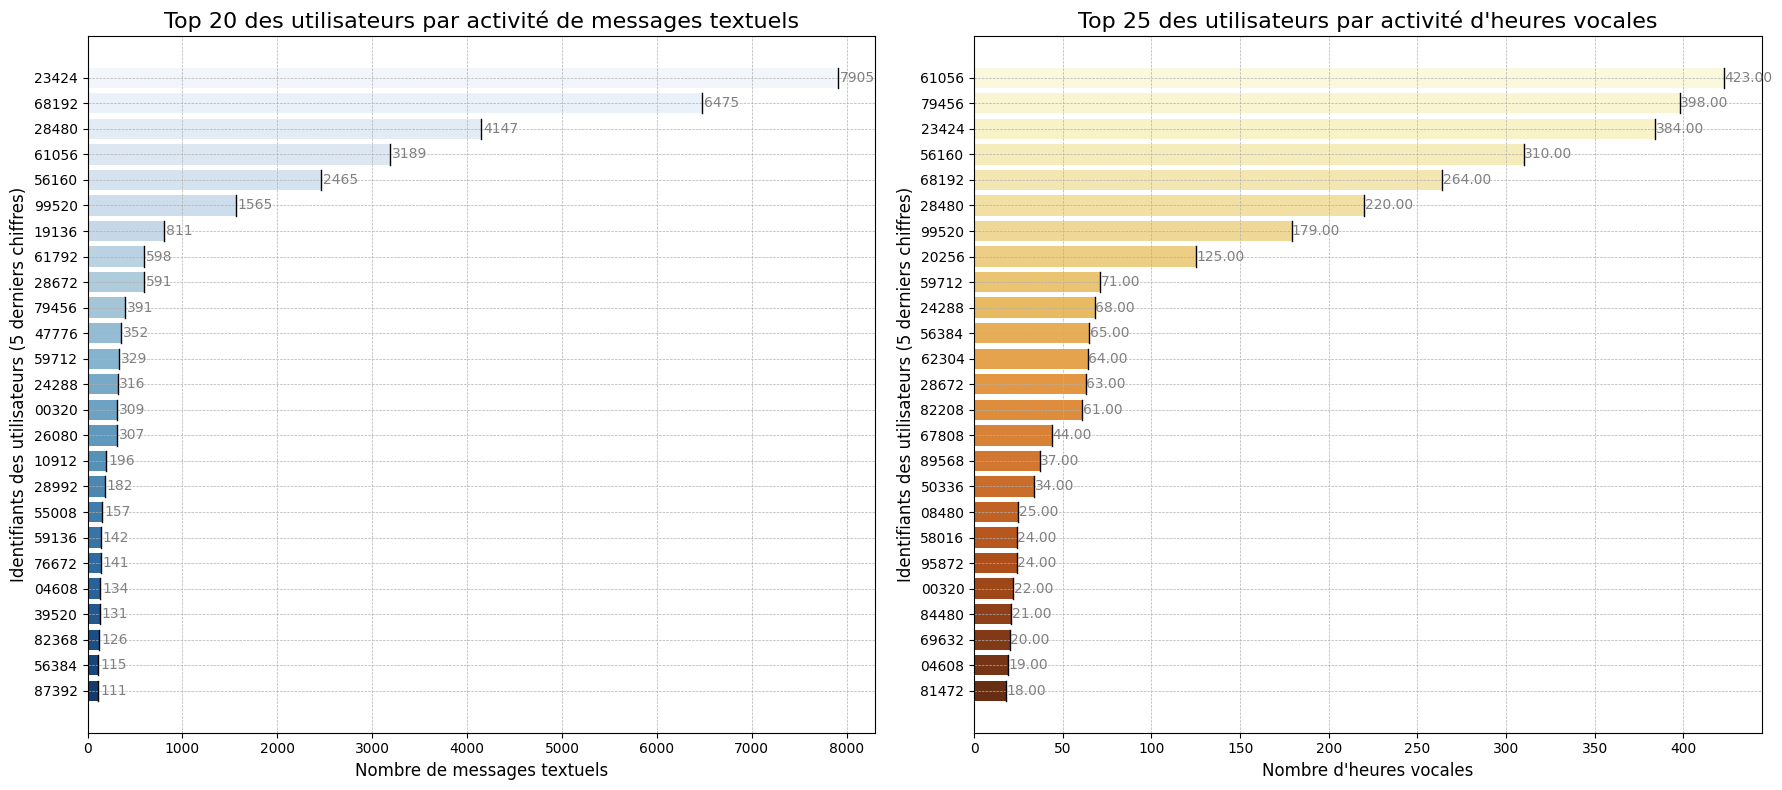

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger vos données réelles
message_data = pd.read_json('data/messagedata.json')
voice_data = pd.read_json('data/voicedata.json')

# Convertir les colonnes de date en datetime
message_data['logDate'] = pd.to_datetime(message_data['logDate'])
voice_data['when'] = pd.to_datetime(voice_data['when'])

# Agréger les données pour les utilisateurs les plus actifs
top_users_text = message_data['discordid'].apply(lambda x: str(x)[-5:]).value_counts().nlargest(25).reset_index()
top_users_text.columns = ['discordid_short', 'text_activity']

top_users_voice = voice_data['discordid'].apply(lambda x: str(x)[-5:]).value_counts().nlargest(25).reset_index()
top_users_voice.columns = ['discordid_short', 'voice_activity']

# Création des graphiques séparés
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # Un graphique avec deux sous-graphes

# Graphique 1 : Top 20 utilisateurs par messages textuels
sns.barplot(data=top_users_text.sort_values('text_activity', ascending=False), 
            x='text_activity', y='discordid_short', palette='Blues', ax=axes[0])
axes[0].set_title('Top 25 des utilisateurs par activité de messages textuels', fontsize=16)
axes[0].set_xlabel('Nombre de messages textuels', fontsize=12)
axes[0].set_ylabel('Identifiants des utilisateurs (5 derniers chiffres)', fontsize=12)
axes[0].grid(True, which='major', linestyle='--', linewidth=0.5)

# Ajouter une ligne de délimitation et les totaux à droite des barres
for index, row in top_users_text.iterrows():
    axes[0].plot([row['text_activity'], row['text_activity']], [index - 0.4, index + 0.4], color='black', linewidth=1)  # Ligne noire
    axes[0].text(row['text_activity'] + 20, index, f"{row['text_activity']}", va='center', ha='left', fontsize=10, color='gray')  # Total à droite

# Graphique 2 : Top 20 utilisateurs par heures vocales
sns.barplot(data=top_users_voice.sort_values('voice_activity', ascending=False), 
            x='voice_activity', y='discordid_short', palette='YlOrBr', ax=axes[1])
axes[1].set_title('Top 25 des utilisateurs par activité d\'heures vocales', fontsize=16)
axes[1].set_xlabel('Nombre d\'heures vocales', fontsize=12)
axes[1].set_ylabel('Identifiants des utilisateurs (5 derniers chiffres)', fontsize=12)
axes[1].grid(True, which='major', linestyle='--', linewidth=0.5)

# Ajouter une ligne de délimitation et les totaux à droite des barres
for index, row in top_users_voice.iterrows():
    axes[1].plot([row['voice_activity'], row['voice_activity']], [index - 0.4, index + 0.4], color='black', linewidth=1)  # Ligne noire
    axes[1].text(row['voice_activity'] + 0.2, index, f"{row['voice_activity']:.2f}", va='center', ha='left', fontsize=10, color='gray')  # Total à droite

# Ajuster l'espacement et l'affichage
plt.tight_layout()
plt.show()


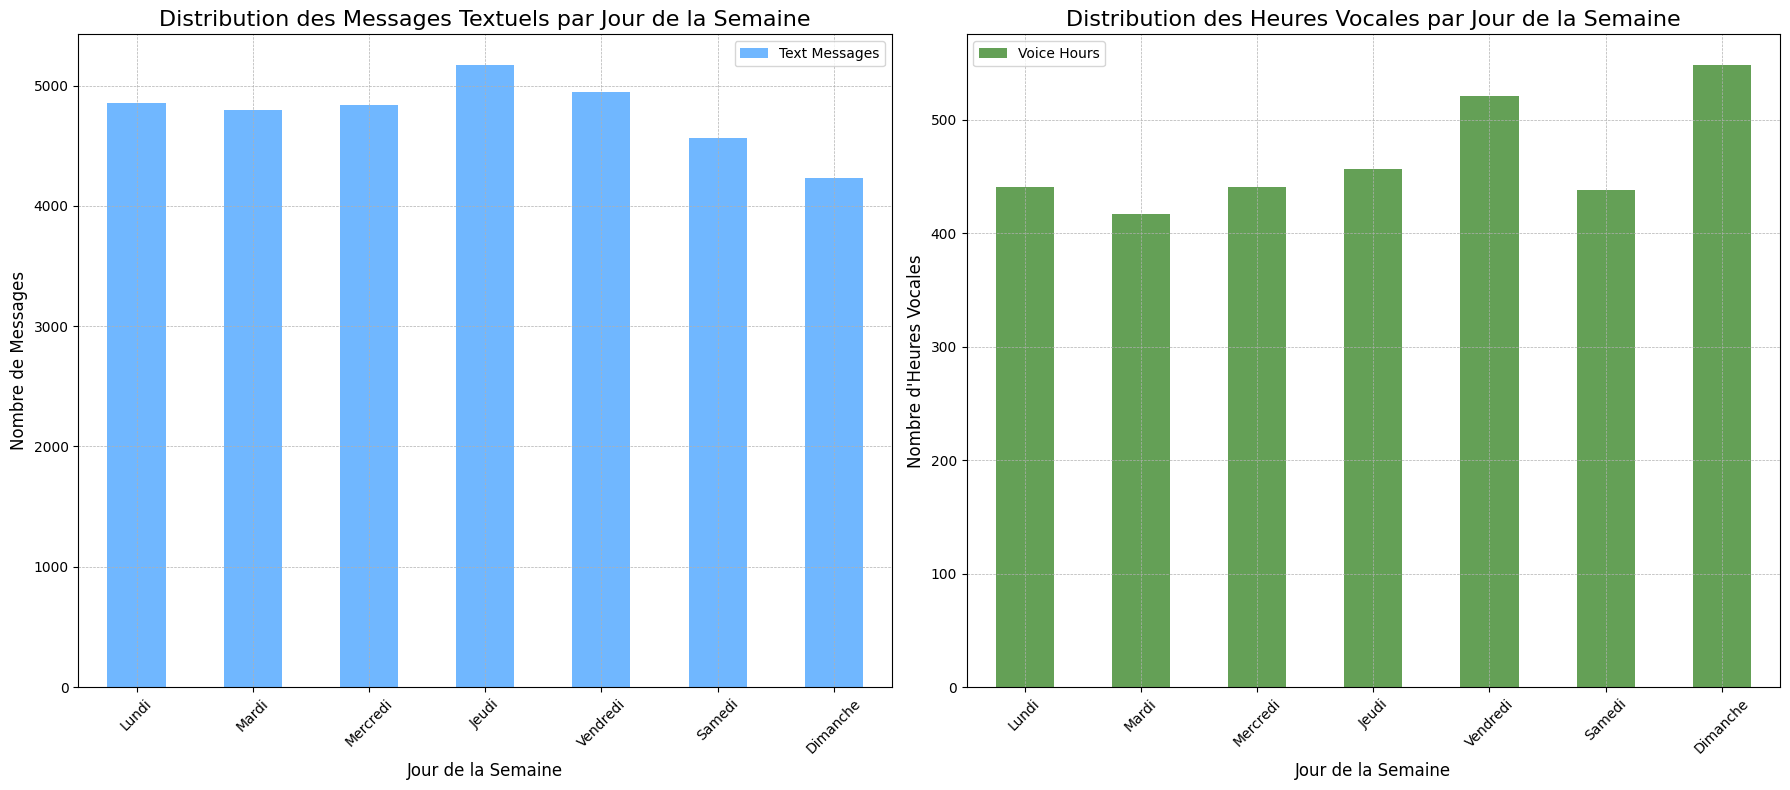

In [138]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger vos données réelles
message_data = pd.read_json('data/messagedata.json')
voice_data = pd.read_json('data/voicedata.json')

# Convertir les colonnes de date en datetime
message_data['logDate'] = pd.to_datetime(message_data['logDate'], errors='coerce')  # Conversion explicite
voice_data['when'] = pd.to_datetime(voice_data['when'], errors='coerce')  # Conversion explicite

# Calculer la distribution de l'activité par jour de la semaine pour les messages textuels
weekday_text = message_data['logDate'].dt.day_name().value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).fillna(0)

# Calculer la distribution de l'activité par jour de la semaine pour les heures vocales
weekday_voice = voice_data['when'].dt.day_name().value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).fillna(0)

# Traduction des jours de la semaine en français
day_translation = {
    'Monday': 'Lundi',
    'Tuesday': 'Mardi',
    'Wednesday': 'Mercredi',
    'Thursday': 'Jeudi',
    'Friday': 'Vendredi',
    'Saturday': 'Samedi',
    'Sunday': 'Dimanche'
}

# Remplacer les noms de jours en anglais par les jours en français
weekday_text.index = weekday_text.index.map(day_translation)
weekday_voice.index = weekday_voice.index.map(day_translation)

# Créer un DataFrame pour combiner les données
weekday_data = pd.DataFrame({
    'Text Messages': weekday_text,
    'Voice Hours': weekday_voice
}).reset_index()
weekday_data.columns = ['Day', 'Text Messages', 'Voice Hours']

# Création de la figure avec deux sous-graphiques pour séparer les messages et les heures vocales
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # Un graphique avec deux sous-graphes

# Graphique 1 : Distribution des messages textuels par jour de la semaine
weekday_data.plot(kind='bar', x='Day', y='Text Messages', ax=axes[0], color='#3399FF', alpha=0.7)
axes[0].set_title('Distribution des Messages Textuels par Jour de la Semaine', fontsize=16)
axes[0].set_xlabel('Jour de la Semaine', fontsize=12)
axes[0].set_ylabel('Nombre de Messages', fontsize=12)
axes[0].grid(True, linestyle='--', linewidth=0.5)

# Incliner les étiquettes des jours pour les messages textuels
axes[0].tick_params(axis='x', rotation=45)

# Graphique 2 : Distribution des heures vocales par jour de la semaine
weekday_data.plot(kind='bar', x='Day', y='Voice Hours', ax=axes[1], color='#22780F', alpha=0.7)
axes[1].set_title('Distribution des Heures Vocales par Jour de la Semaine', fontsize=16)
axes[1].set_xlabel('Jour de la Semaine', fontsize=12)
axes[1].set_ylabel('Nombre d\'Heures Vocales', fontsize=12)
axes[1].grid(True, linestyle='--', linewidth=0.5)

# Incliner les étiquettes des jours pour les heures vocales
axes[1].tick_params(axis='x', rotation=45)

# Ajuster l'espacement et l'affichage
plt.tight_layout()
plt.show()


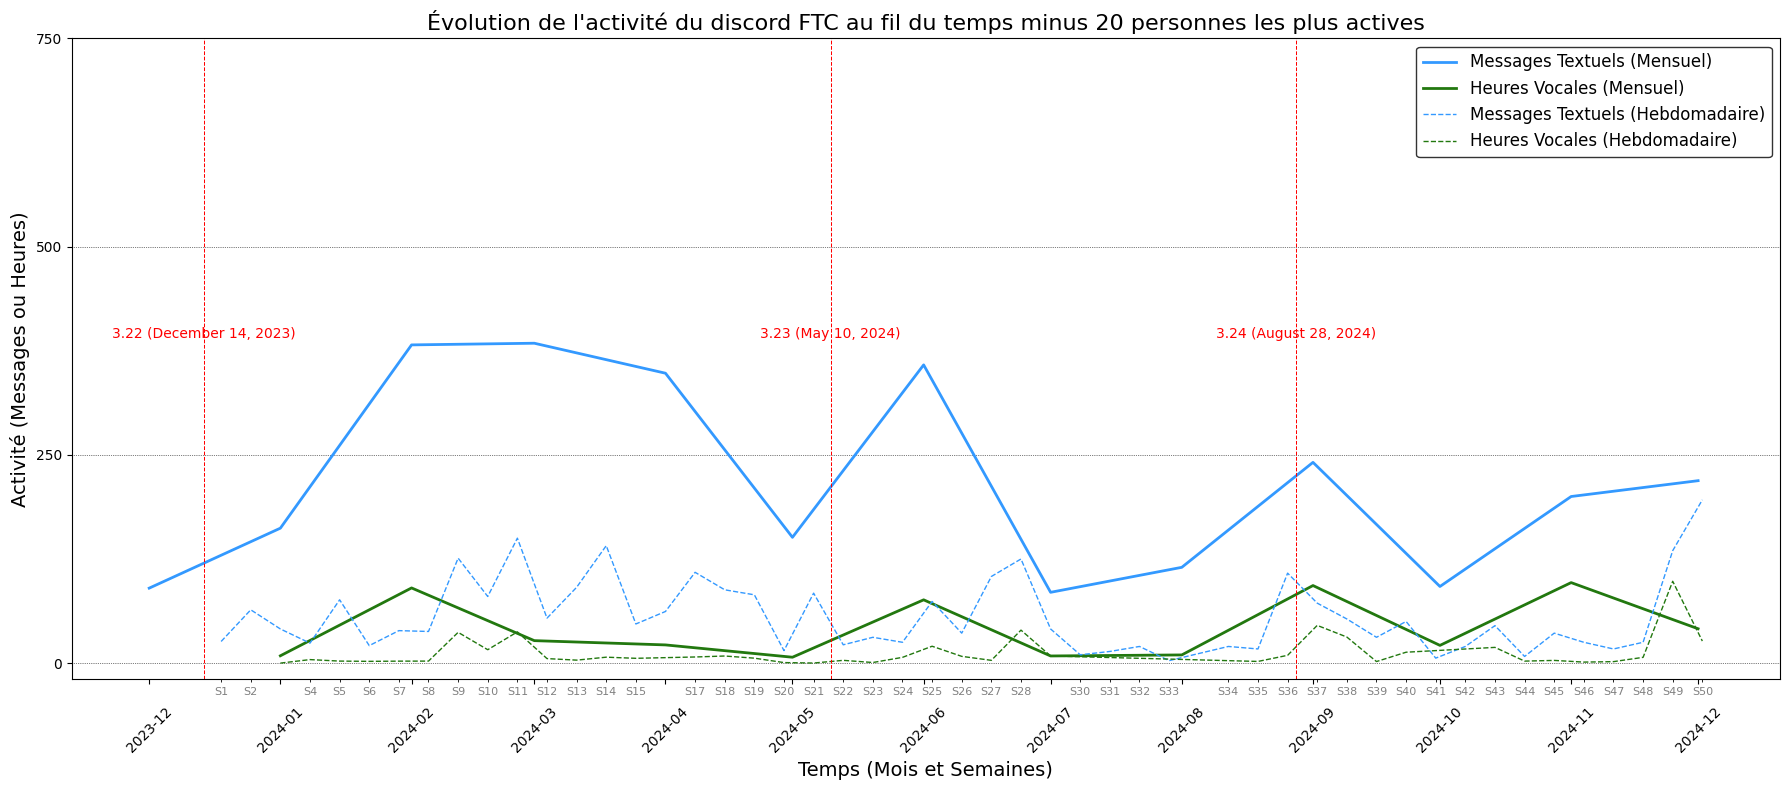

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Charger vos données réelles
message_data = pd.read_json('data/messagedata.json')
voice_data = pd.read_json('data/voicedata.json')

# Charger le fichier events.json
with open('data/events.json', 'r') as file:
    events_data = json.load(file)

# Convertir les colonnes de date en datetime
message_data['logDate'] = pd.to_datetime(message_data['logDate'])
voice_data['when'] = pd.to_datetime(voice_data['when'])

# Convertir la durée de la voix de secondes en heures
voice_data['duration_hours'] = voice_data['duration'] / 3600

# Calculer les périodes mensuelles et hebdomadaires pour les messages textuels et les heures vocales
message_data['month'] = message_data['logDate'].dt.to_period('M')
voice_data['month'] = voice_data['when'].dt.to_period('M')

message_data['week'] = message_data['logDate'].dt.to_period('W').dt.to_timestamp()
voice_data['week'] = voice_data['when'].dt.to_period('W').dt.to_timestamp()

# Calculer les utilisateurs les plus actifs en messages textuels et heures vocales
top_users_text = message_data['discordid'].value_counts().nlargest(20).index
top_users_voice = voice_data['discordid'].value_counts().nlargest(20).index

# Filtrer les données pour exclure les top 20 utilisateurs les plus actifs en messages et en heures vocales
filtered_message_data = message_data[~message_data['discordid'].isin(top_users_text)]
filtered_voice_data = voice_data[~voice_data['discordid'].isin(top_users_voice)]

# Agréger les données par mois et semaine après avoir exclu les top 20 utilisateurs
text_monthly = filtered_message_data.groupby('month').size().reset_index(name='messages')
voice_monthly = filtered_voice_data.groupby('month')['duration_hours'].sum().reset_index(name='hours')

text_weekly = filtered_message_data.groupby('week').size().reset_index(name='messages')
voice_weekly = filtered_voice_data.groupby('week')['duration_hours'].sum().reset_index(name='hours')

# Utiliser le style par défaut avec fond blanc
plt.style.use('default')  # Utilisation du style par défaut avec fond blanc

# Création du graphique linéaire avec une largeur plus grande
plt.figure(figsize=(18, 8))  # Augmenter la largeur du graphique

# Tracer les courbes mensuelles pour les messages textuels et les heures vocales
plt.plot(text_monthly['month'].dt.to_timestamp(), text_monthly['messages'], label='Messages Textuels (Mensuel)', color='#3399FF', linewidth=2)  # Bleu clair
plt.plot(voice_monthly['month'].dt.to_timestamp(), voice_monthly['hours'], label='Heures Vocales (Mensuel)', color='#22780F', linewidth=2)  # Vert

# Tracer les courbes hebdomadaires pour les messages textuels et les heures vocales
plt.plot(text_weekly['week'], text_weekly['messages'], label='Messages Textuels (Hebdomadaire)', color='#3399FF', linestyle='--', linewidth=1)  # Bleu pastel
plt.plot(voice_weekly['week'], voice_weekly['hours'], label='Heures Vocales (Hebdomadaire)', color='#22780F', linestyle='--', linewidth=1)  # Vert

# Ajouter des événements spéciaux (lignes verticales rouges)
for event in events_data['events']:
    event_date = pd.to_datetime(event['release_date'])
    plt.axvline(x=event_date, color='red', linestyle='--', linewidth=0.725)  # Lignes verticales rouges
    # Ajouter l'annotation avec le nom du patch et la date
    plt.text(event_date, plt.gca().get_ylim()[1], f"{event['version']} ({event['release_date']})", 
             color='red', fontsize=10, ha='center', va='top')

# Ajouter des étiquettes et des titres
plt.title('Évolution de l\'activité du discord FTC au fil du temps minus 20 personnes les plus actives', fontsize=16, color='black')
plt.xlabel('Temps (Mois et Semaines)', fontsize=14, color='black')
plt.ylabel('Activité (Messages ou Heures)', fontsize=14, color='black')

# Ajuster les labels des mois et des semaines
ax = plt.gca()

# Affichage des mois avec une inclinaison de 45 degrés pour éviter le chevauchement
ax.set_xticks(text_monthly['month'].dt.to_timestamp())
ax.set_xticklabels([date.strftime('%Y-%m') for date in text_monthly['month']], fontsize=10, color='black')
plt.xticks(rotation=45)  # Inclinaison des vignettes des mois à 45 degrés

# Affichage des semaines (petites vignettes) avec plus d'espace
week_labels = ['S' + str(i+1) for i in range(len(text_weekly))]
ax.set_xticks(text_weekly['week'], minor=True)
ax.set_xticklabels(week_labels, minor=True, fontsize=8, color='gray')

# Ajuster les labels des ordonnées pour des séparations de 250 et 1000
ax.set_yticks(range(0, int(max(text_monthly['messages'].max(), voice_monthly['hours'].max())) + 500, 250))
ax.yaxis.grid(True, which='major', linestyle=':', linewidth=0.5, color='black')  # Grille pour l'axe des ordonnées

# Ajouter une légende
plt.legend(facecolor='white', edgecolor='black', fontsize=12)

# Ajuster la marge du graphique pour les vignettes des mois (top margin)
plt.subplots_adjust(top=0.85)  # Augmenter l'espace en haut

# Ajuster l'espacement entre les vignettes des mois et des semaines
plt.gca().tick_params(axis='x', which='major', pad=15)  # Espace entre les vignettes des mois et des semaines

# Afficher le graphique
plt.tight_layout()
plt.show()


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_3032\4053291700.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users_text.sort_values('text_activity', ascending=False),
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_3032\4053291700.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users_voice.sort_values('voice_activity', ascending=False),


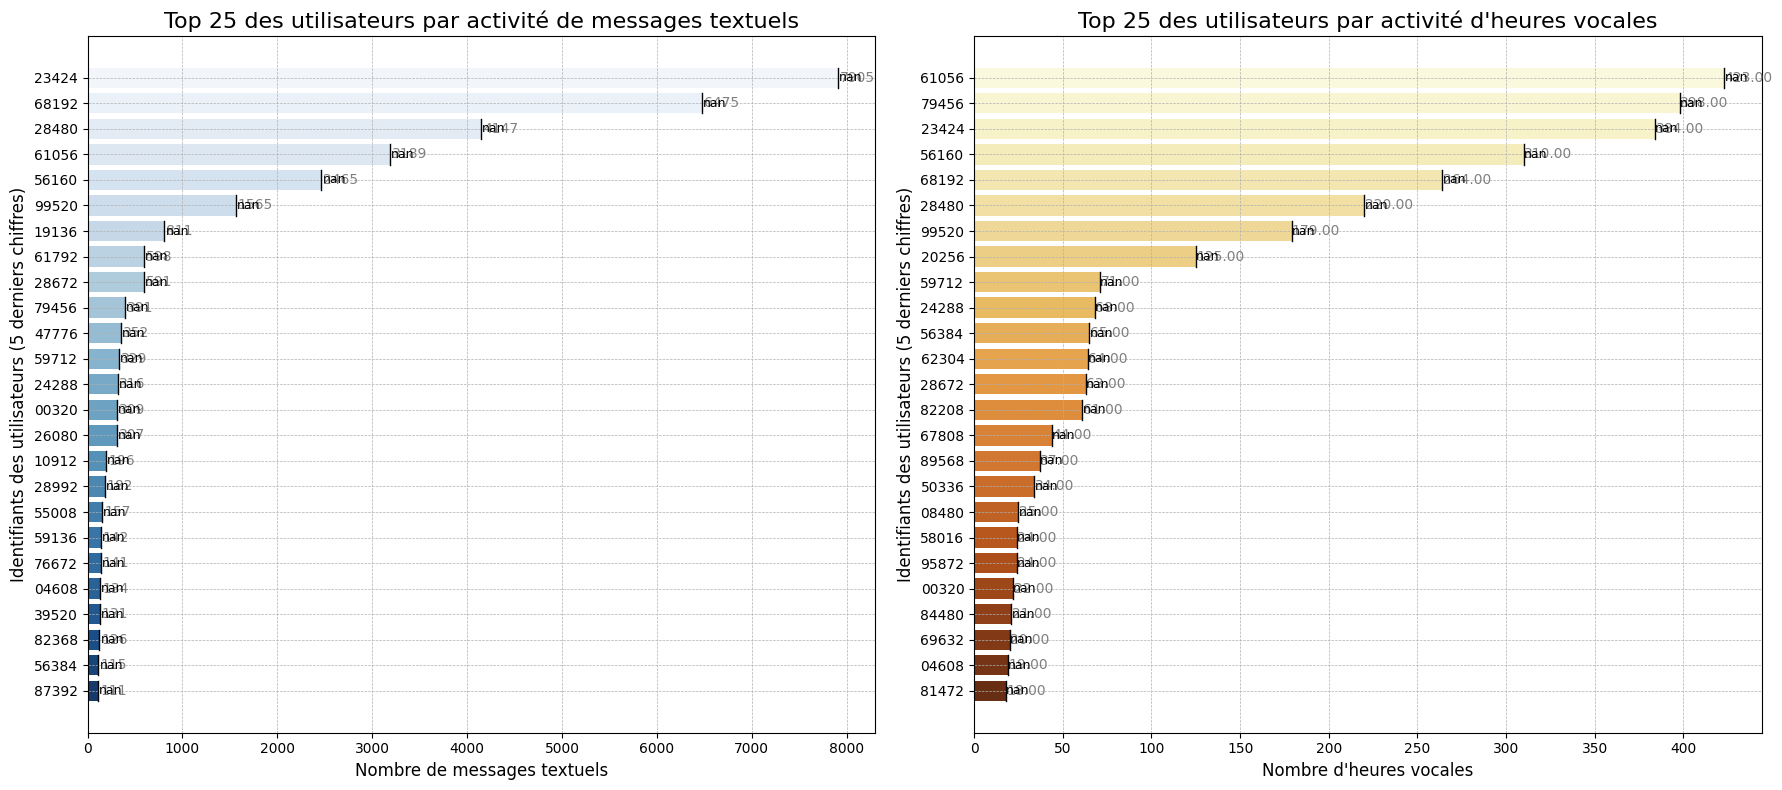

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Charger vos données réelles
message_data = pd.read_json('data/messagedata.json')
voice_data = pd.read_json('data/voicedata.json')

# Charger les données de users.json pour obtenir les pseudos
with open('data/users.json', 'r') as file:
    users_data = json.load(file)
    
# Créer un DataFrame avec les utilisateurs
users_df = pd.DataFrame(users_data)

# Convertir les colonnes de date en datetime
message_data['logDate'] = pd.to_datetime(message_data['logDate'])
voice_data['when'] = pd.to_datetime(voice_data['when'])

# Agréger les données pour les utilisateurs les plus actifs
top_users_text = message_data['discordid'].apply(lambda x: str(x)[-5:]).value_counts().nlargest(25).reset_index()
top_users_text.columns = ['discordid_short', 'text_activity']

top_users_voice = voice_data['discordid'].apply(lambda x: str(x)[-5:]).value_counts().nlargest(25).reset_index()
top_users_voice.columns = ['discordid_short', 'voice_activity']

# Ajouter les pseudos des utilisateurs dans les DataFrames top_users
top_users_text = top_users_text.merge(users_df[['id', 'username']], left_on='discordid_short', right_on='id', how='left')
top_users_voice = top_users_voice.merge(users_df[['id', 'username']], left_on='discordid_short', right_on='id', how='left')

# Création des graphiques séparés
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # Un graphique avec deux sous-graphes

# Graphique 1 : Top 25 utilisateurs par messages textuels
sns.barplot(data=top_users_text.sort_values('text_activity', ascending=False), 
            x='text_activity', y='discordid_short', palette='Blues', ax=axes[0])
axes[0].set_title('Top 25 des utilisateurs par activité de messages textuels', fontsize=16)
axes[0].set_xlabel('Nombre de messages textuels', fontsize=12)
axes[0].set_ylabel('Identifiants des utilisateurs (5 derniers chiffres)', fontsize=12)
axes[0].grid(True, which='major', linestyle='--', linewidth=0.5)

# Ajouter une ligne de délimitation et les totaux à droite des barres
for index, row in top_users_text.iterrows():
    axes[0].plot([row['text_activity'], row['text_activity']], [index - 0.4, index + 0.4], color='black', linewidth=1)  # Ligne noire
    axes[0].text(row['text_activity'] + 20, index, f"{row['text_activity']}", va='center', ha='left', fontsize=10, color='gray')  # Total à droite
    axes[0].text(row['text_activity'] + 10, index, f"{row['username']}", va='center', ha='left', fontsize=9, color='black')  # Pseudo à côté de l'ID

# Graphique 2 : Top 25 utilisateurs par heures vocales
sns.barplot(data=top_users_voice.sort_values('voice_activity', ascending=False), 
            x='voice_activity', y='discordid_short', palette='YlOrBr', ax=axes[1])
axes[1].set_title('Top 25 des utilisateurs par activité d\'heures vocales', fontsize=16)
axes[1].set_xlabel('Nombre d\'heures vocales', fontsize=12)
axes[1].set_ylabel('Identifiants des utilisateurs (5 derniers chiffres)', fontsize=12)
axes[1].grid(True, which='major', linestyle='--', linewidth=0.5)

# Ajouter une ligne de délimitation et les totaux à droite des barres
for index, row in top_users_voice.iterrows():
    axes[1].plot([row['voice_activity'], row['voice_activity']], [index - 0.4, index + 0.4], color='black', linewidth=1)  # Ligne noire
    axes[1].text(row['voice_activity'] + 0.2, index, f"{row['voice_activity']:.2f}", va='center', ha='left', fontsize=10, color='gray')  # Total à droite
    axes[1].text(row['voice_activity'] + 0.1, index, f"{row['username']}", va='center', ha='left', fontsize=9, color='black')  # Pseudo à côté de l'ID

# Ajuster l'espacement et l'affichage
plt.tight_layout()
plt.show()
